In [ ]:
import os
import clr

sz_exp_path = "/Users/andrew/neuroscore/KMO Mice Males Cohort 1"
# Update the path to the .dll files
dll_folder = "/Users/andrew/neuroscore"  # Replace with the actual path to your .dll files
extractor_dll = os.path.join(dll_folder, "Ponemah6xExtractor.dll")
sqlite_dll_folder = "/Users/andrew/neuroscore"  # Replace with the actual path to SQLite.Interop.dll

channel_id = 2
num_samples_requested = 100000

import clr
from System import Array
from System import DateTime

from datetime import timedelta
sample_rate = 500
import clr
import os

def GetPnmWaveformData_Setup(sz_exp_path, channel_id, num_samples_requested):
    # Initialize arrays
    seg_start_times_utc = []
    seg_end_times_utc = []
    clr.AddReference(os.path.join(dll_folder, "Ponemah.WaveformFile.dll"))
    clr.AddReference(os.path.join(dll_folder, 'Ponemah6xExtractor.dll'))

    from Ponemah6xExtractor import Ponemah6XExtractor
    from Ponemah.WaveformFile import WaveformDatasetReader

    # Get Experiment database
    sz_exp_name = os.path.basename(sz_exp_path)
    sz_exp_database = os.path.join(sz_exp_path, f"{sz_exp_name}.PnmExp")

    # Retrieve available channels
    reader = WaveformDatasetReader()
    reader.OpenDataset(sz_exp_path)
    reader.ScanForAvailableData()
    channel_ids = list(reader.GetChannelIds())

    # Verify requested channelId is valid
    if channel_id not in channel_ids:
        raise ValueError("Invalid channel")
    
    # Retrieve segments from the Waveform file
    time_segments = reader.GetChannelTimeSegments(channel_id)

    # Populate segment start and end times
    for segment in time_segments:
        seg_start_times_utc.append(segment.Start)
        seg_end_times_utc.append(segment.End)
        
    # Allocate a float buffer for internal use
    from System import Array, Single
    sample_buffer = Array.CreateInstance(Single, num_samples_requested)
    timezone = -1
    return reader, timezone, seg_start_times_utc, seg_end_times_utc, sample_rate, sample_buffer

def GetPnmWaveformDataUtc(reader, channel_id, start_time_utc, num_samples_requested, sample_buffer, sample_rate, seg_start_times_utc, seg_end_times_utc):
    # Identify the data segment that contains the requested data
    for idx in range(len(seg_start_times_utc)):
        if start_time_utc < seg_start_times_utc[idx]:
            start_time_utc = seg_start_times_utc[idx]
            end_time_utc = seg_end_times_utc[idx]
            break
        if seg_start_times_utc[idx] <= start_time_utc <= seg_end_times_utc[idx]:
            end_time_utc = seg_end_times_utc[idx]
            break
    else:
        raise ValueError("No samples available")

    # Start from the first sample at or after the requested time
    actual_start_time_utc = start_time_utc

    # Adjust the number of samples based on available contiguous data
    range_duration = end_time_utc - start_time_utc
    available_samples = range_duration.Ticks * sample_rate / 10000000

    if available_samples < num_samples_requested:
        num_samples_requested = int(available_samples)

    # Retrieve data
    samples_returned = reader.GetSamples(channel_id, start_time_utc, sample_buffer, num_samples_requested)
    print(samples_returned)
    return actual_start_time_utc, samples_returned


reader, timezone, seg_start_times_utc, seg_end_times_utc, sample_rate, sample_buffer = GetPnmWaveformData_Setup(
    sz_exp_path, channel_id, num_samples_requested
)

for seg_idx in range(len(seg_start_times_utc)):
    print(seg_idx)
    current_utc = seg_start_times_utc[seg_idx]
    seg_end_utc = seg_end_times_utc[seg_idx]
    print(current_utc)
    print(seg_end_utc)
    actual_start_time_utc, samples_returned = GetPnmWaveformDataUtc(
        reader, channel_id, current_utc, num_samples_requested, sample_buffer, sample_rate, seg_start_times_utc, seg_end_times_utc
    )

0
7/16/2021 5:27:25 PM
7/16/2021 5:29:03 PM
49050
1
7/16/2021 8:54:33 PM
7/19/2021 11:13:09 AM
100000


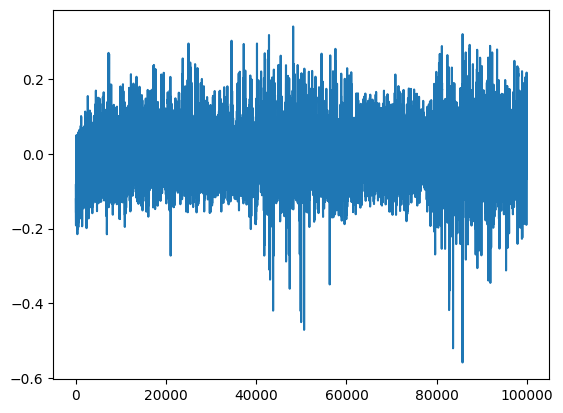

In [26]:
import numpy as np
import matplotlib.pyplot as plt
X = np.array(sample_buffer)
plt.plot(X)

In [ ]:





# Verify requested channelId is valid
if channel_id not in channel_ids:
    raise ValueError("Invalid channel")

# Get Segments start and end times
seg_start_times_utc, seg_end_times_utc = GetTimeSegmentsUtc(sz_exp_path, channel_id)
ticks_per_sample = GetTicksPerSample(reader, channel_id, seg_start_times_utc[0])
sample_rate = 10000000 / ticks_per_sample.Ticks  # Assumes constant sample rate

# Allocate a float buffer for internal use
from System import Array, Single
sample_buffer = Array.CreateInstance(Single, num_samples_requested)

return reader, timezone, seg_start_times_utc, seg_end_times_utc, sample_rate, sample_buffer